<h1><b>인공지능개론 6주차 수업실습<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>Tensorflow 분류(car_evaluation.csv)<br></b></h1>

---



<h2><b>0. 라이브러리 import(분류)</b></h2>

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# tensorflow관련 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

<h2><b>1. 데이터 로딩</b></h2>

In [60]:
# URL
url = "https://raw.githubusercontent.com/harjotspahwa/Car-Evaluation/master/car_evaluation.csv"

# 컬럼 이름 지정
column_names = ['price',	'maint',	'doors',	'persons',	'lug_capacity',	'safety', 'output']

# URL에서 직접 CSV 불러오기
df = pd.read_csv(url, header=None, names=column_names)  # 이미 컬럼명이 포함된 경우는 header=0, 없으면 header=None + names=column_names

df.to_csv("car_evaluation_with_columns.csv", index=False)
# 데이터 확인
df

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [61]:
# 컬렴명 확인
print(df.columns)

Index(['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety',
       'output'],
      dtype='object')


<h2><b>2. 결측치 확인</b></h2>

In [62]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: 결측치가 확인되지않음

price           0
maint           0
doors           0
persons         0
lug_capacity    0
safety          0
output          0
dtype: int64


<h2><b>3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수(target)의 분포를 확인</li>

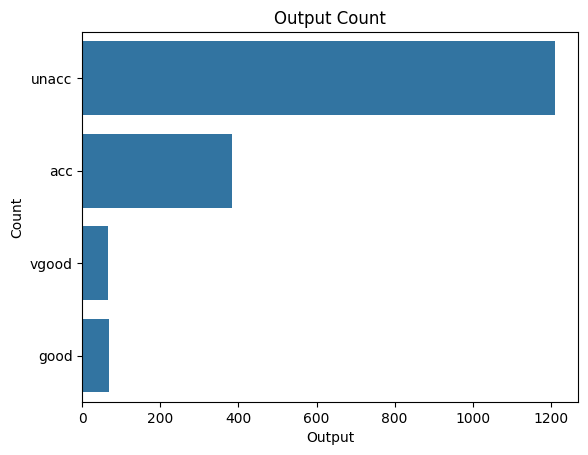

,count
output,
unacc,1210
acc,384
good,69
vgood,65


In [63]:
# 레이블 갯수 확인 (그래프)
sns.countplot(df['output'])
plt.xlabel("Output")
plt.ylabel("Count")
plt.title("Output Count")
plt.show()

# 레이블 갯수 확인 (숫자)
df['output'].value_counts()


분포확인 결과 vgood과 good이 unacc와 acc보다 현저히 적어 많이 등장하는 클래스에만 모델이 집중하게 되고, 드물게 등장하는 클래스는 무시하게 되는 경향이 생김(bias). 따라서 정확도는 높지만 실제로는 쓸모 없는 예측 모델이 됨(많이 등장하는 클래스를 더 잘 예측했기 때문에 드물게 등장하는 클래스를 맞히지 못해도 비율적으로 정확도는 높게 나옴). 모델 생성/학습 단계에서 class_weight적용 필요.   
class_weight: 소수 클래스에 가중치를 더 부여해서, 손실함수(loss)가 그쪽을 더 민감하게 반영하도록 도와줌

<h2><b>4. 데이터 전처리</b></h2>

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf

# 피처(X), 라벨(y) 분리
X = df.drop('output', axis=1)
y = df['output']

# 범주형 값을 숫자로 변환 (Label Encoding)
le_dict = {}
for col in X.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le  # 나중에 디코딩할 수 있게 저장

# 출력 라벨도 숫자로 변환
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. 확인
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (1382, 6)
X_test shape: (346, 6)
y_train shape: (1382,)
y_test shape: (346,)


<h2><b>5. 모델 정의 & 컴파일 </b></h2>

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight

# 입력 피처 개수 확인
input_dim = X_train.shape[1]  # 6개


# class_weight 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# 모델 정의
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # 과적합 방지
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')  # 클래스 수에 맞게 출력층
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # 라벨 인코딩된 y값일 경우 사용
    metrics=['accuracy']
)


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,124 (12.20 KB)

 Trainable params: 3,124 (12.20 KB)

 Non-trainable params: 0 (0.00 B)

<h2><b>6. 모델 학습 </b></h2>

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',       # 검증 손실 기준
    patience=3,               # 3 에폭 연속 향상 없으면 멈춤
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,  # 더 작게 해서 학습 섬세하게
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2308 - loss: 1.2895 - val_accuracy: 0.5921 - val_loss: 1.2400
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4801 - loss: 1.2108 - val_accuracy: 0.5884 - val_loss: 1.0802
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5450 - loss: 1.0931 - val_accuracy: 0.5884 - val_loss: 0.9828
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5757 - loss: 0.9038 - val_accuracy: 0.5596 - val_loss: 0.9654
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5289 - loss: 0.9958 - val_accuracy: 0.5596 - val_loss: 0.9407
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6003 - loss: 0.9012 - val_accuracy: 0.5704 - val_loss: 0.9084
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5617 - loss: 0.8359 - val_accuracy: 0.5740 - val_loss: 0.9318
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6218 - loss: 0.8455 - val_accuracy: 0

<h2><b>7. 학습곡선 시각화 </b></h2>

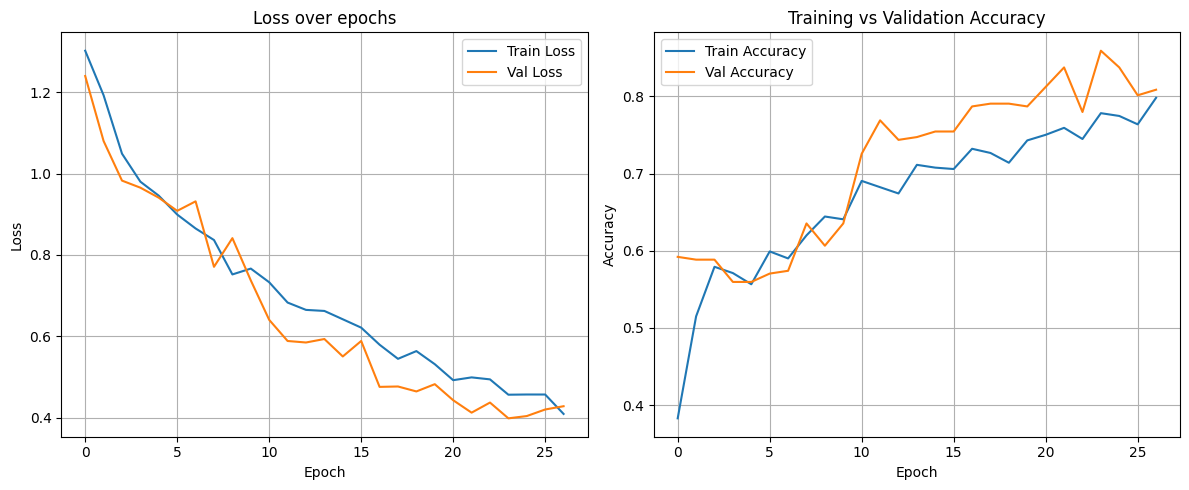

In [67]:
# 서브플롯 생성 (1행 2열)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 왼쪽: 손실 그래프
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Val Loss')
axs[0].set_title('Loss over epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# 오른쪽: 정확도 그래프
axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[1].set_title('Training vs Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

<h2><b>8. 모델 평가 </b></h2>

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8021 - loss: 0.4840

Test Accuracy: 82.37%

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Classification Report:
              precision    recall  f1-score   support

         acc       0.67      0.66      0.67        83
        good       0.35      1.00      0.52        11
       unacc       0.95      0.87      0.91       235
       vgood       0.78      0.82      0.80        17

    accuracy                           0.82       346
   macro avg       0.69      0.84      0.73       346
weighted avg       0.86      0.82      0.83       346



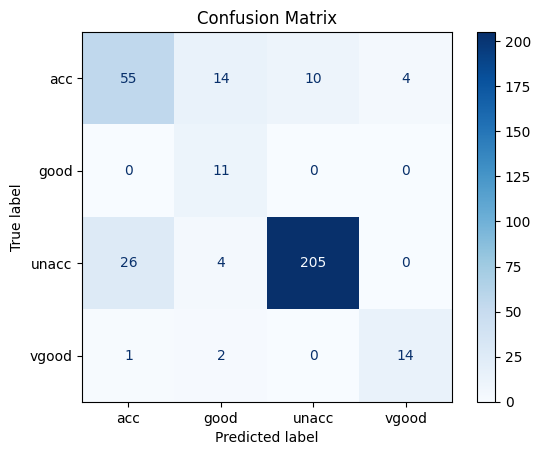

In [68]:
# 8. 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.2%}\n")

# 9. 예측 및 분석
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# 라벨 복원
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# 분류 리포트 출력
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# 혼동 행렬
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

<h2><b>9. 새롭게 넣어본 기능의 성능 평가 </b></h2>

| 버전                                      | Accuracy | `good` Recall | `vgood` Recall | Macro Avg F1 |
|-------------------------------------------|----------|----------------|------------------|---------------|
| class_weight 없음                         | 83.2%    | 0.00           | 0.00             | 0.41          |
| class_weight만 적용                       | 66.7%    | 0.73           | 1.00             | 0.54          |
| 개선된 설계 적용(Dropout, EarlyStopping) | **82.4%**| **1.00**       | **0.82**         | **0.73**      |
